In [1]:
import wandb
from collections import defaultdict
import pandas as pd
import numpy as np

import random

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display_html
import os

%load_ext autoreload
%autoreload 2

In [2]:
COLORS = {}
COLORS["MSCN"] = "#4260f5"
COLORS["MSCN (Ours)"] = "Green"

In [3]:
api = wandb.Api()

In [3]:
runs = api.runs("pari/MyCEB",
    {"$and": [
       {"config.algs": "mscn"},
       {"config.train_test_split_kind":"query"},
       {"config.query_dir":"queries/imdb-unique-plans"},
       {"config.eval_on_job":1},
       {"config.eval_on_jobm":0},
       {"config.num_samples_per_template":-1},
       {"config.feat_separate_alias":0},
       {"config.weight_decay":0},
       {"$or": [
#             {"$and": [
#                 {"tags":"v13"},
#                 {"config.loss_func_name":"flowloss"},
#             ]},
           {"tags":"v17"},
       ]} 
    ]
    })

print(f"Found {len(runs)} runs")

Found 40 runs


In [4]:
SAVE_DIR = "/Users/pari/Desktop/"
#/Users/pari/Desktop

In [5]:
import time
start = time.time()

dfs = []

for run in runs:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    dfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)

took:  0.2385880947113037


In [6]:
df = pd.concat(dfs)

In [7]:
print(len(df))

33


In [8]:
df.head(5)

,Tags,name,lr,pwd,algs,port,seed,user,opt_lr,skip7a,...,Final-Relative-TotalPPCost-test-8a,Final-Relative-TotalPPCost-train-11b,Final-PPError-test-mean,Final-Relative-TotalPPCost-val-4a,QError-val,PostgresPlanCost-C-Relative-val,QError-job,QError-test,PostgresPlanCost-C-Relative-test,PostgresPlanCost-C-Relative-job
0,"[evalep, v17]",sage-glade-10563,0.0001,password,mscn,5431,123,ceb,0.001,0,...,1.807,1.301,4.261520e+06,1.603,NaN,NaN,NaN,NaN,NaN,NaN
0,"[evalep, v17]",winter-planet-10562,0.0001,password,mscn,5431,123,ceb,0.001,0,...,1.788,1.281,7.917840e+06,1.427,NaN,NaN,NaN,NaN,NaN,NaN
0,"[evalep, v17]",azure-jazz-10561,0.0001,password,mscn,5431,123,ceb,0.001,0,...,1.793,1.293,5.346130e+06,1.658,NaN,NaN,NaN,NaN,NaN,NaN
0,"[evalep, v17]",stellar-plant-10560,0.0001,password,mscn,5431,123,ceb,0.001,0,...,3.910,1.485,4.343050e+06,1.669,NaN,NaN,NaN,NaN,NaN,NaN
0,"[evalep, v17]",effortless-blaze-10559,0.0001,password,mscn,5431,123,ceb,0.001,0,...,3.881,1.455,6.264912e+06,1.669,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df = df[df.epoch >= 2]
df = df[df.max_discrete_featurizing_buckets.isin([1,10])]
df = df[df.hidden_layer_size.isin([128, 256])]
df = df[df.skip7a == 0]
print(len(df))

24


In [10]:
print(set(df["table_features"]))
print(set(df["join_features"]))
print(set(df["set_column_feature"]))
print(set(df["max_discrete_featurizing_buckets"]))
#print(set(df["mask_unseen_subplans"]))
print(set(df["onehot_dropout"]))
#print(set(df["onehot_mask_truep"]))
print(set(df["loss_func_name"]))
print(set(df["hidden_layer_size"]))

{1}
{'onehot'}
{'onehot', 'onehot-stats'}
{1, 10}
{0, 2}
{'mse', 'flowloss'}
{128}


In [11]:
def get_row_featurization(row):
    ret = ""
    if row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["loss_func_name"] == "mse" \
        and row["ynormalization"] == "log" \
        and row["load_query_together"] == 0 \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 0:
        if row["sample_bitmap"] == 0 and row["max_discrete_featurizing_buckets"] == 10 and \
            row["max_like_featurizing_buckets"] == 10:
            ret = "Default"
        elif row["sample_bitmap"] == 1:
            ret = "Default + Sample Bitmap-" \
            + str(row["max_discrete_featurizing_buckets"]) \
            + str(row["max_like_featurizing_buckets"])
        elif row["join_bitmap"] == 1 and row["sample_bitmap"] == 0:
            ret = "Default + Join Bitmap-" \
            + str(row["max_discrete_featurizing_buckets"]) \
            + str(row["max_like_featurizing_buckets"])
        elif row["join_bitmap"] == 1 and row["sample_bitmap"] == 1:
            ret = "Default + Sample Bitmap + Join Bitmap-" \
            + str(row["max_discrete_featurizing_buckets"]) \
            + str(row["max_like_featurizing_buckets"])
        else:
            ret = "Default (unknown)"
    elif row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["loss_func_name"] == "qloss" \
        and row["ynormalization"] == "log" \
        and row["load_query_together"] == 0 \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 0 \
        and row["sample_bitmap"] == 1 \
        and row["heuristic_features"] == 0:
        ret = "MSCN-original"       
    elif row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["max_discrete_featurizing_buckets"] == 1 \
        and row["max_like_featurizing_buckets"] == 1 \
        and row["loss_func_name"] == "mse" \
        and row["load_query_together"] == 0 \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 0:
        ret = "Default (onehot, no-buckets)"
    elif row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "mse" \
        and row["load_query_together"] == 0 \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 2 \
        and row["heuristic_features"] == 1:
        ret = "Default-dropout-" + str(row["onehot_mask_truep"])
    elif row["loss_func_name"] == "flowloss":
        ret = "FlowLoss"
        if row["onehot_dropout"] == 2:
            ret += "-Dropout"
        if row["normalize_flow_loss"] == 0:
            ret += "-Norm0"
        if row["sample_bitmap"]:
            ret += "-SBitmap"
        if row["join_bitmap"]:
            ret += "-JBitmap"
        if "stats" in row["join_features"] or "stats" in row["set_column_feature"]:
            ret += "-Stats"
            
#         if row["table_features"] == 1 \
#             and row["set_column_feature"] in ["1", 1, "onehot"] \
#             and row["join_features"] in ["1", 1, "onehot"] \
#             and row["max_discrete_featurizing_buckets"] == 10 \
#             and row["max_like_featurizing_buckets"] == 10 \
#             and row["weight_decay"] == 0 \
#             and row["normalize_flow_loss"] == 1 \
#             and row["flow_features"] == 1:
#             ret = "FlowLoss (onehot)"
#         elif row["table_features"] == 1 \
#             and row["set_column_feature"] == "onehot-stats" \
#             and row["join_features"] == "onehot-stats" \
#             and row["max_discrete_featurizing_buckets"] == 10 \
#             and row["max_like_featurizing_buckets"] == 10 \
#             and row["weight_decay"] == 0 \
#             and row["normalize_flow_loss"] == 1 \
#             and row["flow_features"] == 1:
#             ret = "FlowLoss (onehot-stats)"
#         elif row["table_features"] == 1 \
#             and row["set_column_feature"] == "onehot-stats" \
#             and row["join_features"] == "onehot-stats" \
#             and row["max_discrete_featurizing_buckets"] == 10 \
#             and row["max_like_featurizing_buckets"] == 10 \
#             and row["loss_func_name"] == "flowloss" \
#             and row["weight_decay"] == 0 \
#             and row["normalize_flow_loss"] == 1 \
#             and row["flow_features"] == 1 \
#             and row["onehot_dropout"] == 2:
#             ret = "FlowLoss (onehot-stats-dropout)"
#     elif row["table_features"] == 1 \
#         and row["set_column_feature"] in ["1", 1, "onehot"] \
#         and row["join_features"] in ["1", 1, "onehot"] \
#         and row["max_discrete_featurizing_buckets"] == 10 \
#         and row["max_like_featurizing_buckets"] == 10 \
#         and row["loss_func_name"] == "flowloss" \
#         and row["weight_decay"] == 0 \
#         and row["normalize_flow_loss"] == 0 \
#         and row["flow_features"] == 1:
#         ret = "FlowLoss2 (onehot)"
    elif row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "mse+ranknet" \
        and row["load_query_together"] == 1:
        ret = "MSE+ranknet"
    
    elif row["table_features"] == 1 \
        and row["set_column_feature"] == "onehot-stats" \
        and row["join_features"] == "onehot-stats" \
        and row["loss_func_name"] == "mse" \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 2:
        if row["sample_bitmap"] == 1:
            ret = "Onehot-Stats-Dropout-Bitmap-" + \
            str(row["max_discrete_featurizing_buckets"]) + "-" + \
            str(row["max_like_featurizing_buckets"]) + "-" + \
            str(row["max_epochs"]) + "-" + \
            str(row["onehot_mask_truep"])
        else:
            ret = "Onehot-Stats-Dropout-" + str(row["max_discrete_featurizing_buckets"]) + "-" +\
            str(row["max_like_featurizing_buckets"]) + "-" + \
            str(row["max_epochs"]) + "-" + \
            str(row["onehot_mask_truep"])
        
    elif row["table_features"] == 1 \
        and row["set_column_feature"] == "onehot" \
        and row["join_features"] == "onehot" \
        and row["loss_func_name"] == "mse" \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 2:
        if row["sample_bitmap"] == 1:
            ret = "Onehot-Dropout-Bitmap-" + \
            str(row["max_discrete_featurizing_buckets"]) + "-" + \
            str(row["max_like_featurizing_buckets"]) + "-" + \
            str(row["max_epochs"]) + "-" + \
            str(row["onehot_mask_truep"])
        else:
            ret = "Onehot-Dropout-" + str(row["max_discrete_featurizing_buckets"]) + "-" +\
            str(row["max_like_featurizing_buckets"]) + "-" + \
            str(row["max_epochs"]) + "-" + \
            str(row["onehot_mask_truep"])
        
    elif row["table_features"] == 1 \
        and row["set_column_feature"] == "onehot-stats" \
        and row["join_features"] == "onehot-stats" \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "mse" \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] > 0 \
        and row["max_epochs"] == 20:
        ret = "Onehot-Stats-dropout" + str(row["onehot_dropout"])
    elif row["table_features"] == 0 \
        and row["set_column_feature"] == "stats" \
        and row["join_features"] == "stats" \
        and row["loss_func_name"] == "mse" \
        and row["weight_decay"] == 0:
        ret = "OnlyStats"
    else:
        ret = "unknown"
    
    if row["feat_separate_like_ests"] == 1:
        ret += "-sepLike"
    
    if row["feat_true_base_cards"] == 1:
        ret += "-trueBase"
        
    if row["early_stopping"] in [1,2]:
        ret += "-ES" + str(int(row["early_stopping"]))
    
    return ret

In [12]:
df["Featurization"] = df.apply(lambda x: get_row_featurization(x), axis=1)

In [13]:
print(set(df["Featurization"]))

{'unknown', 'Default (unknown)', 'Default', 'FlowLoss', 'Onehot-Dropout-1-1-20-0.8-ES2', 'Default + Join Bitmap-11', 'Default + Sample Bitmap-11', 'FlowLoss-Dropout-JBitmap-ES2', 'Onehot-Dropout-1-1-20-0.8'}


In [14]:
df.groupby(["Featurization"]).count()

,Tags,name,lr,pwd,algs,port,seed,user,opt_lr,skip7a,...,Final-Relative-TotalPPCost-test-8a,Final-Relative-TotalPPCost-train-11b,Final-PPError-test-mean,Final-Relative-TotalPPCost-val-4a,QError-val,PostgresPlanCost-C-Relative-val,QError-job,QError-test,PostgresPlanCost-C-Relative-test,PostgresPlanCost-C-Relative-job
Featurization,,,,,,,,,,,,,,,,,,,,,
Default,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
Default (unknown),3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,0,0,0,0,0,0
Default + Join Bitmap-11,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,0,0,0,0,0,0
Default + Sample Bitmap-11,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,0,0,0,0,0,0
FlowLoss,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,0,0,0,0,0,0
FlowLoss-Dropout-JBitmap-ES2,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,0,0,0,0
Onehot-Dropout-1-1-20-0.8,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,0,0,0,0,0,0
Onehot-Dropout-1-1-20-0.8-ES2,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,0,0,0,0
unknown,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [15]:
print(set(df["Featurization"]))

{'unknown', 'Default (unknown)', 'Default', 'FlowLoss', 'Onehot-Dropout-1-1-20-0.8-ES2', 'Default + Join Bitmap-11', 'Default + Sample Bitmap-11', 'FlowLoss-Dropout-JBitmap-ES2', 'Onehot-Dropout-1-1-20-0.8'}


In [16]:
pdf = df[df.Featurization.isin(['Default + Sample Bitmap-11',
                                #'Default',
                                #'Default (unknown)',
                                #'unknown', 
                                'FlowLoss-Dropout-JBitmap-ES2',
                                #'Default + Join Bitmap-11-ES2', 
                                #'FlowLoss-JBitmap-ES2', 
                                'Onehot-Dropout-1-1-20-0.8-ES2', 
                                #'Default + Join Bitmap-11', 
                                #'Onehot-Dropout-1-1-20-0.8'
                                'FlowLoss'
                               ])]
ci = None
estimator = np.mean
#SEEDS = [7, 13, 14, 17, 19, 20]
#pdf = pdf[pdf.diff_templates_seed.isin(SEEDS)]
#pdf

Text(0.5, 0, 'Model')

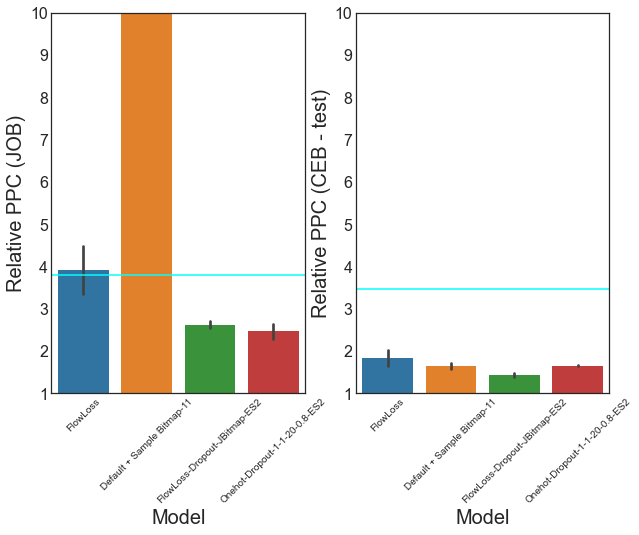

In [18]:
ci = "sd"
plt.style.use("seaborn-white")
fig, axs = plt.subplots(figsize=(10,7), nrows=1, ncols=2)

ymax = max(max(pdf["Final-Relative-TotalPPCost-job-all_job"].values), 
           max(pdf["Final-Relative-TotalPPCost-test"].values))
ymax = 10

ax = axs[0]
sns.barplot(x="Featurization", y="Final-Relative-TotalPPCost-job-all_job", hue="Featurization", data=pdf, 
           ax=ax, ci=ci, estimator=estimator, dodge=False)

ax.axhline(y=3.8, color="cyan")
ax.set_ylim([1.0, ymax])

ax.set_ylabel("Relative PPC (JOB)", fontsize=20)
ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', which='major', labelsize=10, rotation=45)
ax.set_xlabel("Model", fontsize=20)

ax.legend().remove()

ax = axs[1]
sns.barplot(x="Featurization", y="Final-Relative-TotalPPCost-test", hue="Featurization", data=pdf, 
           ax=ax, ci=ci, estimator=estimator, dodge=False)

ax.axhline(y=3.465, color="cyan")

ax.set_ylim([1.0, ymax])

ax.set_ylabel("Relative PPC (CEB - test)", fontsize=20)
ax.tick_params(axis='x', which='major', labelsize=10, rotation=45)
ax.legend().remove()

ax.tick_params(axis='y', which='major', labelsize=16)

ax.set_xlabel("Model", fontsize=20)

<ipython-input-73-a5772e51efd5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["Featurization"] = pdf.apply(lambda x: new_names[x["Featurization"]] ,axis=1)


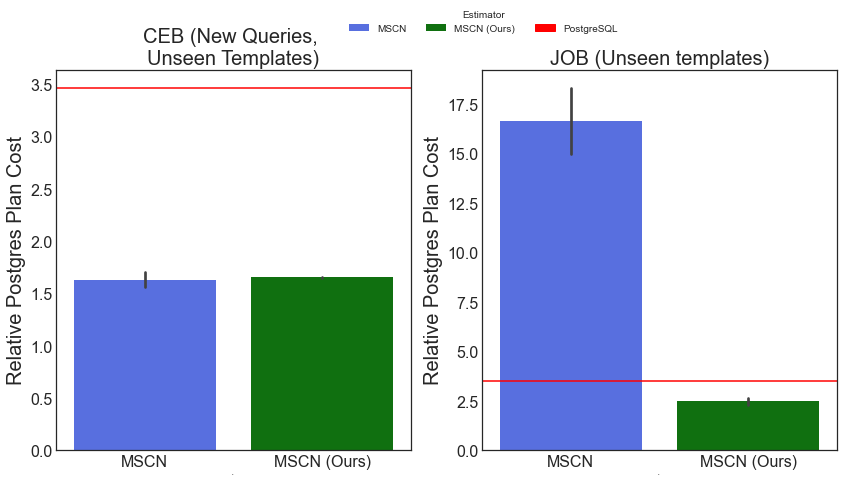

In [73]:
import matplotlib.patches as mpatches

ci = "sd"
plt.style.use("seaborn-white")
fig, axs = plt.subplots(figsize=(14,7), nrows=1, ncols=2)

pdf = df[df.Featurization.isin(["Default + Sample Bitmap-11", "Onehot-Dropout-1-1-20-0.8-ES2"])]

new_names = {}
new_names["Default + Sample Bitmap-11"] = "MSCN"
new_names["Onehot-Dropout-1-1-20-0.8-ES2"] = "MSCN (Ours)"

pdf["Featurization"] = pdf.apply(lambda x: new_names[x["Featurization"]] ,axis=1)

ymax = max(max(pdf["Final-Relative-TotalPPCost-job-all_job"].values), 
           max(pdf["Final-Relative-TotalPPCost-test"].values))

ax = axs[0]
sns.barplot(x="Featurization", y="Final-Relative-TotalPPCost-test", hue="Featurization", data=pdf, 
           ax=ax, ci=ci, estimator=estimator, dodge=False,
           palette=COLORS)

ax.axhline(y=3.465, color="red")

#ax.set_ylim([1.0, ymax])

ax.set_title("CEB (New Queries, \nUnseen Templates)", fontsize=20)
ax.set_ylabel("Relative Postgres Plan Cost", fontsize=20)
ax.tick_params(axis='x', which='major', labelsize=16, rotation=0)

ax.legend().remove()
#legend = ax.legend(loc='upper left', bbox_to_anchor=(1.0,1.18))
legend = ax.legend(loc='upper left', bbox_to_anchor=(0.8,1.18), ncol=3)
handles, labels = ax.get_legend_handles_labels()
red_patch = mpatches.Patch(color='red', label='PostgreSQL')
handles.append(red_patch)
labels.append("PostgreSQL")

legend._legend_box = None
legend._init_legend_box(handles, labels)
legend._set_loc(legend._loc)
legend.set_title("Estimator")

#ax.legend(legend=legend, bbox_to_anchor=(1.0,1.1))

ax.tick_params(axis='y', which='major', labelsize=16)

#ax.set_xlabel("Model", fontsize=16)
ax.set_xlabel("Model", fontsize=0)

ax = axs[1]
sns.barplot(x="Featurization", y="Final-Relative-TotalPPCost-job-all_job", hue="Featurization", data=pdf, 
           ax=ax, ci=ci, estimator=estimator, dodge=False,
           palette=COLORS)

ax.axhline(y=3.5, color="red")
#ax.set_ylim([1.0, ymax])

ax.set_ylabel("Relative Postgres Plan Cost", fontsize=20)
ax.set_title("JOB (Unseen templates)", fontsize=20)

ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', which='major', labelsize=16, rotation=0)
#ax.set_xlabel("Model", fontsize=16)
ax.set_xlabel("Model", fontsize=0)

ax.legend().remove()

plt.savefig("JOB-PPC-Relative.pdf")

In [90]:
pdf = df[df.Featurization.isin([#'Default + Sample Bitmap-11',
                                #'Default',
                                #'Default (unknown)',
                                #'unknown', 
                                #'FlowLoss-Dropout-JBitmap-ES2',
                                #'Default + Join Bitmap-11-ES2', 
                                #'FlowLoss-JBitmap-ES2', 
                                'Onehot-Dropout-1-1-20-0.8-ES2', 
                                'Default + Join Bitmap-11', 
                                'Onehot-Dropout-1-1-20-0.8'
                                #'FlowLoss'
                               ])]
ci = None
estimator = np.mean
#SEEDS = [7, 13, 14, 17, 19, 20]
#pdf = pdf[pdf.diff_templates_seed.isin(SEEDS)]
#pdf

# Ablations

Text(0.5, 0, 'Model')

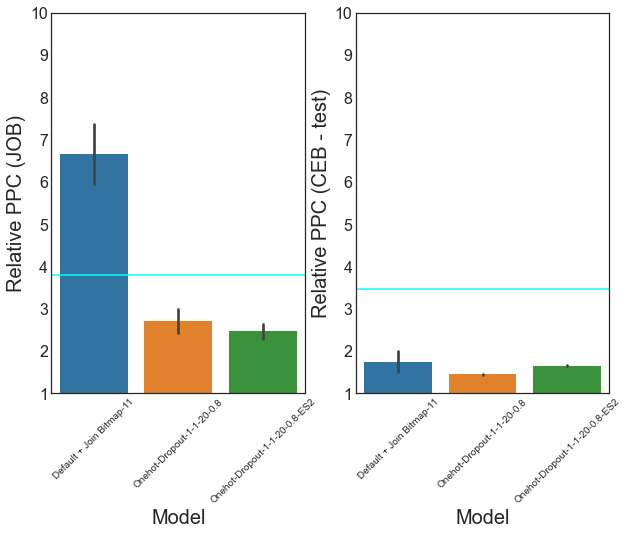

In [91]:
ci = "sd"
plt.style.use("seaborn-white")
fig, axs = plt.subplots(figsize=(10,7), nrows=1, ncols=2)

ymax = max(max(pdf["Final-Relative-TotalPPCost-job-all_job"].values), 
           max(pdf["Final-Relative-TotalPPCost-test"].values))
ymax = 10

ax = axs[0]
sns.barplot(x="Featurization", y="Final-Relative-TotalPPCost-job-all_job", hue="Featurization", data=pdf, 
           ax=ax, ci=ci, estimator=estimator, dodge=False)

ax.axhline(y=3.8, color="cyan")
ax.set_ylim([1.0, ymax])

ax.set_ylabel("Relative PPC (JOB)", fontsize=20)
ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', which='major', labelsize=10, rotation=45)
ax.set_xlabel("Model", fontsize=20)

ax.legend().remove()

ax = axs[1]
sns.barplot(x="Featurization", y="Final-Relative-TotalPPCost-test", hue="Featurization", data=pdf, 
           ax=ax, ci=ci, estimator=estimator, dodge=False)

ax.axhline(y=3.465, color="cyan")

ax.set_ylim([1.0, ymax])

ax.set_ylabel("Relative PPC (CEB - test)", fontsize=20)
ax.tick_params(axis='x', which='major', labelsize=10, rotation=45)
ax.legend().remove()

ax.tick_params(axis='y', which='major', labelsize=16)

ax.set_xlabel("Model", fontsize=20)